In [12]:
import dill 
dill.load_session('globalsave.pkl')


In [3]:
import pandas as pd 
import math
import os
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import Image, set_matplotlib_formats
from matplotlib.patches import Ellipse, transforms

import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import expit

import numpy as onp
import numpyro as numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import effective_sample_size, print_summary
from numpyro.infer import MCMC, NUTS, Predictive
numpyro.set_platform("gpu")
numpyro.set_host_device_count(4)

# Data

In [146]:
import pandas as pd
d = pd.read_csv('jeff/small_dat.csv')
d.shape

(500, 72)

In [163]:
only_repeated_measurment = True
new_id = True
if only_repeated_measurment:
    unique_values, counts = np.unique(d.i_ID, return_counts=True)
    duplicates = unique_values[counts == 2]
    d_rep = d[np.isin(d.i_ID, duplicates)]
    if new_id:
        seq = np.arange(0, len(duplicates), 1)
        id_map = dict(zip(duplicates, seq))
        new_ids_to_replace = np.array([id_map.get(id, id) for id in d_rep.i_ID.values])
        d_rep['i_ID_new'] = new_ids_to_replace

    cats = d_rep.iloc[:,1:62]
    N = d_rep.shape[0]
    K = d_rep.K.unique()[0]-1
    ni = len(d_rep.i_ID.unique())
    i_ID = jnp.array(d_rep.i_ID_new.values)
    y = jnp.array(cats.values)
else:
    d = d.iloc[0:500, :]
    d.shape
    cats = d.iloc[:,1:62]
    N = d.shape[0]
    K = d.K.unique()[0]-1
    ni = d.ni.unique()[0]-1
    i_ID = jnp.array(d.i_ID.values)
    y = jnp.array(cats.values)

/tmp/ipykernel_706/403664811.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_rep['i_ID_new'] = new_ids_to_replace


# Simulated data

In [1]:
import json
with open('sim.json', 'r') as f:
    d = json.load(f)

In [2]:
d.keys()

dict_keys(['K', 'N', 'a', 'z_individual', 'L_individual', 'Sigma_individual', 'b_individual', 'N_obs', 'Y', 'id'])

In [4]:
N = d['N']*d['N_obs']
K = d['K']
ni = d['N']
y = jnp.array(d['Y']).reshape(d['N']*d['N_obs'], K)
i_ID = jnp.array( [x - 1 for x in d['id']])

# Model

In [5]:
def model(K, ni, y, i_ID, N):
    a =  numpyro.sample('a', dist.Normal(0,1).expand([K]))
    Sigma_individual = numpyro.sample("Sigma_individual", dist.Exponential(1).expand([ni]))
    L_individual =  numpyro.sample('L_individual', dist.LKJCholesky(ni, 50))
    z_individual = numpyro.sample("z_individual", dist.Normal(0, 1).expand([ni, K]))
    alpha = numpyro.deterministic("alpha", ((Sigma_individual[..., None] * L_individual) @ z_individual))
    # Apply softmax along the correct axis
    lk = numpyro.deterministic("alpha_softmax", jnp.exp(a + alpha[i_ID]) / jnp.sum(jnp.exp(a + alpha[i_ID]), axis=-1, keepdims=True))
    numpyro.sample("y", dist.DirichletMultinomial(lk, N), obs=y)
    

In [6]:
from numpyro.infer import init_to_feasible
dat = dict(
    K = K,
    ni = ni,
    y = y,
    i_ID = i_ID, 
    N = N
)
m14_3 = MCMC(NUTS(model, init_strategy = init_to_feasible()), num_warmup=500, num_samples=500, num_chains=1)
m14_3.run(random.PRNGKey(4387510), extra_fields=["diverging"], **dat)
post = m14_3.get_samples()

sample: 100%|██████████| 1000/1000 [00:46<00:00, 21.43it/s, 31 steps of size 1.61e-01. acc. prob=0.90]


## Sigma

In [9]:
jnp.array(d['Sigma_individual'])

Array([0.2493149 , 0.40191466, 2.5527964 , 0.97560316, 0.3456188 ,
       1.1515589 , 1.7813725 , 1.1341411 , 2.0750248 , 0.59766203,
       0.6366719 , 2.019695  , 3.01677   , 0.01297928, 0.01544907,
       0.01437288, 0.54034364, 1.9304991 , 0.5179715 , 0.73396677,
       0.01079994, 0.55401546, 1.6650282 , 0.81480217, 4.104963  ,
       3.2577806 , 0.14903764, 0.42840958, 0.18479997, 0.1561715 ,
       0.3363672 , 1.1421015 , 0.37968245, 0.4442453 , 1.8384659 ,
       1.3773184 , 1.0257418 , 2.2884505 , 0.07954182, 1.2305164 ],      dtype=float32)

In [10]:
jnp.mean(post['Sigma_individual'], axis = 0)

Array([0.10457119, 0.10634337, 0.10651613, 0.10885834, 0.10885989,
       0.11145824, 0.1002351 , 0.10622894, 0.10319809, 0.10642367,
       0.11353576, 0.11347387, 0.11428002, 0.10919069, 0.10419597,
       0.10787193, 0.11218822, 0.10526446, 0.10725173, 0.11152882,
       0.10392669, 0.10687501, 0.11908598, 0.1087344 , 0.1098956 ,
       0.12220382, 0.11791202, 0.10410027, 0.11584312, 0.10845805,
       0.11494579, 0.10755742, 0.11509012, 0.10793887, 0.10412169,
       0.1109379 , 0.11736453, 0.10690604, 0.11189542, 0.10910239],      dtype=float32)

## mean_effects

In [11]:
jnp.array(d['a'])

Array([0.1969516 , 0.06792114, 0.686781  , 0.7923924 , 0.55137783,
       0.18505144, 0.77719766, 0.61005396, 0.3904674 , 0.09050377,
       0.0631976 , 0.4495311 , 0.5583211 , 0.2687225 , 0.2342096 ,
       0.8867605 , 0.01162041, 0.88614917, 0.60467273, 0.0324292 ,
       0.48060754, 0.78821653, 0.8072472 , 0.9726444 , 0.47119996,
       0.8221004 , 0.28517294, 0.26672938, 0.8321796 , 0.16426675],      dtype=float32)

In [12]:
jnp.mean(post['a'], axis = 0)

Array([-0.06605532, -0.0186589 ,  0.057344  ,  0.02398528,  0.01933319,
        0.05236344,  0.02735751,  0.02524866, -0.10193066, -0.02509927,
        0.07525907,  0.06757476,  0.03296292,  0.00342906, -0.00228208,
       -0.00072445,  0.02332454,  0.01998125,  0.06877333,  0.04998641,
        0.10116339,  0.09973715,  0.02542791,  0.0655578 ,  0.08555431,
        0.09279279,  0.10446415,  0.0594115 ,  0.06610962,  0.03654907],      dtype=float32)

## B_individuals

In [16]:
jnp.array(d['b_individual']).reshape(30,40)

Array([[-0.50780874,  0.05454585,  0.198612  , ...,  0.16456638,
         0.08790485, -0.13737383],
       [ 0.30117005, -0.703252  , -0.19236508, ..., -3.1879218 ,
        -4.5372176 , -1.5939853 ],
       [-5.256587  , -3.3444738 ,  6.477766  , ...,  0.2623219 ,
        -0.06981392, -1.7071215 ],
       ...,
       [ 0.6326546 , -3.3296971 ,  0.06693603, ...,  2.1016011 ,
        -0.9500915 ,  1.1469294 ],
       [ 4.6300044 ,  0.4201627 , -1.3435338 , ...,  0.11208959,
        -0.10943596,  0.09340177],
       [-0.226435  , -0.13859817,  0.10382085, ..., -1.3980486 ,
        -0.58234555, -3.688107  ]], dtype=float32)

In [15]:
jnp.mean(post['alpha'], axis = 0)

Array([[ 0.00356143,  0.00786429,  0.00566484, ..., -0.00377409,
         0.00989605, -0.00356842],
       [ 0.01023991,  0.01070082, -0.01068931, ..., -0.00288585,
        -0.00832235, -0.00164284],
       [ 0.0082526 ,  0.00048039, -0.01736246, ...,  0.01209186,
        -0.00359733, -0.00132439],
       ...,
       [ 0.00646656,  0.00761531,  0.01128968, ..., -0.0044726 ,
         0.00118642, -0.00740699],
       [ 0.00526608,  0.00018799, -0.00207568, ...,  0.00934998,
         0.00901818,  0.0158026 ],
       [-0.00358121,  0.00861036,  0.00920254, ...,  0.00432421,
         0.003665  , -0.00457637]], dtype=float32)

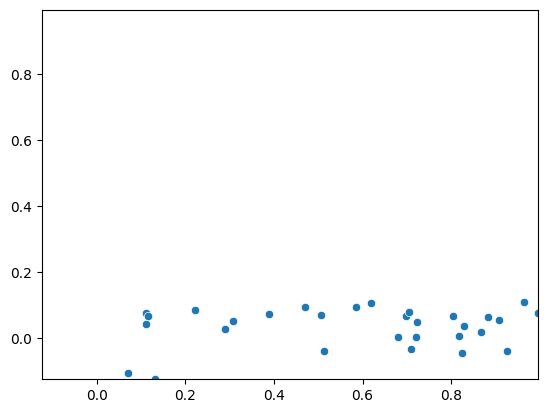

In [539]:
true_random_factors = jnp.array(d['mean_effects'])
estimated_random_factors = jnp.mean(post['a'], axis=0)
tmp1 = np.array(true_random_factors)
tmp2 = np.array(estimated_random_factors)
min_val = np.min([np.min(tmp1), np.min(tmp2)])
max_val = np.max([np.max(tmp1), np.max(tmp2)])
sns.scatterplot(x=tmp1, y=tmp2)
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.show()

# Stan

In [17]:
import numpy as np
tmp = dat
tmp['y'] = np.array(tmp['y'])
tmp['i_ID'] = np.array(tmp['i_ID']+1)
tmp['ni'] = tmp['ni']
tmp['K'] = tmp['K']

In [24]:
import time as tm
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
import numpy as np
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()
stan_code = """ 
data {
    int<lower=0>  N;             // number of observations
    int<lower=0>  K;             // number of occupations
    int ni;                     // NUmber of Unique Individauls
    array[N, K] int y;           // array of observed occupation indicators
    array[N]int<lower=0>  i_ID;     // village indicator for each individual
}
parameters {
    vector[K] a;                    // intercept for each occupation
    matrix[ni, K]  z_individual;    // raw random effect for household 
    cholesky_factor_corr[ni] L_individual; // Cholesky factor for 
    vector<lower=0>[ni] Sigma_individual;

}
transformed parameters{
    matrix[K, ni] b_individual;
    b_individual = (diag_pre_multiply(Sigma_individual, L_individual) * z_individual)';
}
model{
    array[N] vector[K] p;
    matrix[K, N] random_effects;
    to_vector(a) ~ normal(0, 1);
    L_individual ~   lkj_corr_cholesky(2);
    Sigma_individual ~ exponential(1);

    to_vector(z_individual) ~ normal(0, 1);


    // Likelihood for
    for (k in 1:K) {
        for (i in 1:N) {
          random_effects[k, i] = b_individual[k, i_ID[i]];
          p[i,k] =  a[k] + random_effects[k, i];
      }
    }

    for (i in 1:(N)) {
        y[i,] ~ multinomial(softmax(p[i,]));
    }
}
"""

start = tm.time()
stan_model = stan.build(stan_code, data = tmp)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500, init = [{'L_individual': np.zeros((tmp['ni'], tmp['ni']))}])
end = tm.time()    
#df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 26.2s, done.Sampling:   0%

RuntimeError: Exception during call to services function: `RuntimeError("Initialization between (-2, 2) failed after 100 attempts. Try specifying initial values, reducing ranges of constrained values, or reparameterizing the model. Initialization failed. Rejecting initial value: Error evaluating the log probability at the initial value. Exception: dirichlet_multinomial_lpmf: Prior size parameter[1] is -7.22167, but must be positive finite! (in '/tmp/httpstan_lsii6k8h/model_aejnsewf.stan', line 39, column 8 to column 45) Rejecting initial value:")`, traceback: `['  File "/usr/lib/python3.10/asyncio/tasks.py", line 232, in __step\n    result = coro.send(None)\n', '  File "/home/sosa/.local/lib/python3.10/site-packages/httpstan/services_stub.py", line 182, in call\n    raise RuntimeError(exception_message)\n']`

# Comparaison

In [19]:
df = fit.to_frame()
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a.1,a.2,a.3,...,b_individual.21.40,b_individual.22.40,b_individual.23.40,b_individual.24.40,b_individual.25.40,b_individual.26.40,b_individual.27.40,b_individual.28.40,b_individual.29.40,b_individual.30.40
draws,,,,,,,,,,,,,,,,,,,,,
0,-9199.318016,0.997146,0.167658,5.0,31.0,0.0,10275.969743,0.202321,0.267706,0.490763,...,0.000861,0.005815,-0.033738,-0.052418,0.000507,0.035644,-0.037794,0.112226,0.036055,-0.000185
1,-9188.417562,0.970163,0.167658,5.0,31.0,0.0,10253.436027,0.185688,0.120660,0.083192,...,0.023948,-0.124039,0.109873,0.059853,-0.135530,-0.012810,0.024303,0.130914,0.055954,-0.095206
2,-9158.113227,0.953337,0.167658,5.0,31.0,0.0,10254.380059,0.086185,0.023418,0.031475,...,-0.070894,0.102450,0.058573,0.071223,0.189137,-0.080919,0.192540,-0.037435,-0.108977,-0.143027
3,-9135.432138,0.943615,0.167658,5.0,31.0,0.0,10191.778861,0.142744,0.122857,0.244390,...,0.031678,-0.001825,-0.037935,-0.205092,0.056873,-0.031073,0.038526,-0.142384,0.042207,0.122909
4,-9097.375227,0.902459,0.167658,5.0,31.0,0.0,10131.992161,0.095522,0.348760,0.438975,...,-0.116028,0.219817,0.064602,0.112520,-0.010456,-0.084275,0.295891,0.162021,-0.145092,-0.016953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-9130.469834,0.982002,0.167658,5.0,31.0,0.0,10140.550592,-0.035654,0.113599,0.147726,...,-0.083326,-0.037143,-0.054463,-0.043891,0.019183,0.070003,-0.049956,0.001752,0.054682,0.098771
496,-9223.286284,0.777044,0.167658,5.0,31.0,0.0,10200.472087,-0.138872,-0.103679,0.012756,...,-0.040972,0.007591,-0.030316,-0.040881,-0.014416,0.050125,-0.015799,-0.039320,0.044446,0.052336
497,-9178.209435,0.924287,0.167658,5.0,31.0,0.0,10257.535458,0.067250,0.125778,0.182477,...,-0.148635,-0.015265,-0.069755,-0.194293,-0.061249,0.108852,0.010897,0.122982,0.075589,0.010410


In [20]:
[df['a.1'].mean(),df['a.2'].mean(),df['a.3'].mean()]

[-0.01713432654539472, 0.04071679006666144, 0.09980654370873793]

In [21]:
jnp.mean(post['a'], axis = 0)

Array([-0.06605532, -0.0186589 ,  0.057344  ,  0.02398528,  0.01933319,
        0.05236344,  0.02735751,  0.02524866, -0.10193066, -0.02509927,
        0.07525907,  0.06757476,  0.03296292,  0.00342906, -0.00228208,
       -0.00072445,  0.02332454,  0.01998125,  0.06877333,  0.04998641,
        0.10116339,  0.09973715,  0.02542791,  0.0655578 ,  0.08555431,
        0.09279279,  0.10446415,  0.0594115 ,  0.06610962,  0.03654907],      dtype=float32)

In [23]:
jnp.array(d['a'])

Array([0.1969516 , 0.06792114, 0.686781  , 0.7923924 , 0.55137783,
       0.18505144, 0.77719766, 0.61005396, 0.3904674 , 0.09050377,
       0.0631976 , 0.4495311 , 0.5583211 , 0.2687225 , 0.2342096 ,
       0.8867605 , 0.01162041, 0.88614917, 0.60467273, 0.0324292 ,
       0.48060754, 0.78821653, 0.8072472 , 0.9726444 , 0.47119996,
       0.8221004 , 0.28517294, 0.26672938, 0.8321796 , 0.16426675],      dtype=float32)

In [261]:
k = 'z_individual'
for col in df.columns: 
    if col.startswith(k + '.'):
        tmp = col.split('.')
        if int(tmp[1]) == 56 and int(tmp[2]) == 61:
            break

In [265]:
tmp = col.split('.')
s2 = df[col]  

In [290]:
tmp = col.split('.')
s1 = post[k][:, int(tmp[1])-1, int(tmp[2])-1]
s2 = df[col] 

In [291]:
ks_statistic, p_value = ks_2samp(s1, s2)
p_value

0.5600220048872044

In [292]:
contrast = s1 - s2
count_below = np.sum(contrast < -0.25)/len(contrast)
count_above  = np.sum(contrast > 0.25)/len(contrast)
print(count_below)
print(count_above)

0.42
0.414


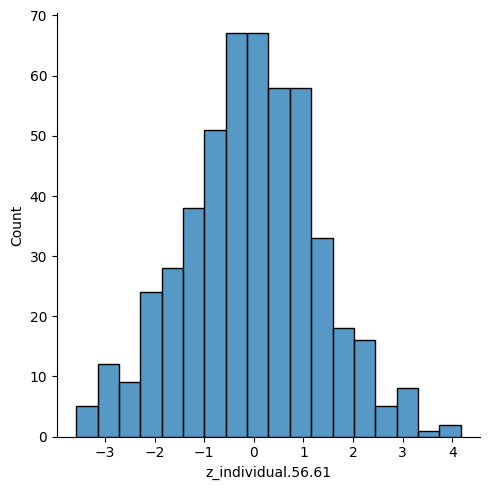

In [302]:
sns.displot(contrast)

In [299]:
np.sum(contrast < -0.25)

210

In [295]:
tmp = pd.DataFrame({"nppro": s1, "stan": s2})

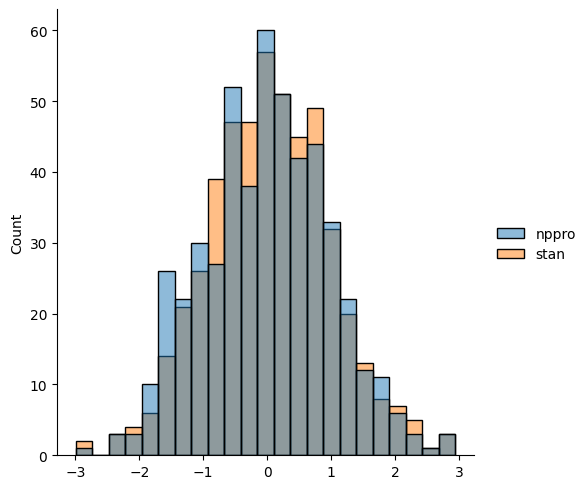

In [296]:
sns.displot(tmp)

In [282]:
contrast

draws
0     -0.637336
1      1.632854
2      1.549115
3     -2.138935
4      0.999482
         ...   
495    0.064943
496    0.127713
497   -0.693684
498   -0.511667
499    0.528356
Name: z_individual.56.61, Length: 500, dtype: float32

In [242]:
from scipy.stats import ks_2samp
comparaison = []
for k in post.keys(): 
    for col in df.columns:        
        if col.startswith(k + '.'):
            #print(k)
            #print(col.split('.'))                
            #print(post[k][0].shape)
            tmp = col.split('.')
            if len(tmp) == 2:
                s1 = post[k][:,int(tmp[1])-1]
                s2 = df[col]   

            if len(tmp) == 3:
                s1 = post[k][:, int(tmp[1])-1, int(tmp[2])-1]
                s2 = df[col] 

            ks_statistic, p_value = ks_2samp(s1, s2)
            contrast = s1 - s2
            count_below = np.sum(contrast < -0.25)/len(contrast)
            count_above  = np.sum(contrast > 0.25)/len(contrast)
            comparaison.append([col, ks_statistic, p_value, contrast, count_below, count_above])

In [243]:
df2 = pd.DataFrame(comparaison, columns=['parameter', 'ks_statistic', 'p_value', 'contrast', 'count_below', 'count_above'])
df2['Nparameter'] = [element.split('.')[0] for element in df2.parameter]
df2['Nparameter_1'] = [int(element.split('.')[1]) for element in df2.parameter]
df2['Nparameter_2'] =  [int(element.split('.')[2]) if len(element.split('.')) >= 3 else None for element in df2.parameter]
df2

,parameter,ks_statistic,p_value,contrast,count_below,count_above,Nparameter,Nparameter_1,Nparameter_2
0,L_individual.1.1,0.000,1.000000e+00,draws 0 0.0 1 0.0 2 0.0 3 ...,0.000,0.000,L_individual,1,1.0
1,L_individual.2.1,0.166,1.975130e-06,draws 0 0.312668 1 -0.366739 2 0...,0.046,0.056,L_individual,2,1.0
2,L_individual.3.1,0.184,8.216964e-08,draws 0 0.134571 1 0.072713 2 0...,0.038,0.058,L_individual,3,1.0
3,L_individual.4.1,0.146,4.575188e-05,draws 0 -0.091578 1 0.015005 2 -0...,0.042,0.052,L_individual,4,1.0
4,L_individual.5.1,0.132,3.237472e-04,draws 0 0.009020 1 -0.113676 2 0...,0.060,0.060,L_individual,5,1.0
...,...,...,...,...,...,...,...,...,...
7376,z_individual.56.61,0.050,5.600220e-01,draws 0 -0.637336 1 1.632854 2 1...,0.420,0.414,z_individual,56,61.0
7377,z_individual.57.61,0.036,9.026912e-01,draws 0 -2.536823 1 -0.037512 2 0...,0.432,0.444,z_individual,57,61.0
7378,z_individual.58.61,0.052,5.089170e-01,draws 0 3.146685 1 -0.581958 2 0...,0.420,0.440,z_individual,58,61.0
7379,z_individual.59.61,0.028,9.896796e-01,draws 0 -1.683309 1 -1.305843 2 -0...,0.430,0.412,z_individual,59,61.0


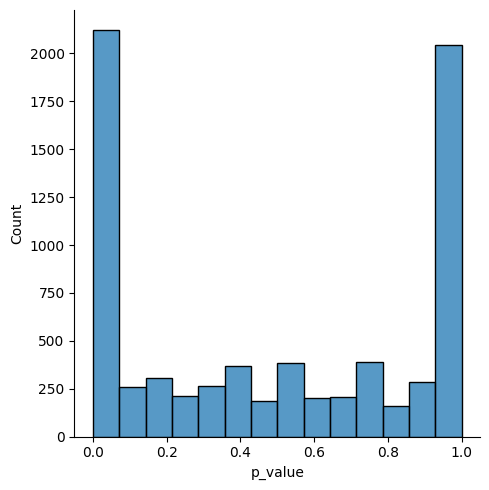

In [272]:
sns.displot(df2.loc[:,'p_value'])

In [274]:
df2[df2.count_below > 0.35].p_value

3603    0.560022
3604    0.459923
3605    0.129396
3606    0.069301
3607    0.413486
          ...   
7376    0.560022
7377    0.902691
7378    0.508917
7379    0.989680
7380    0.095465
Name: p_value, Length: 3734, dtype: float64

In [275]:
df2[df2.count_below > 0.35].loc[:, ['p_value','count_below']]

,p_value,count_below
3603,0.560022,0.446
3604,0.459923,0.360
3605,0.129396,0.402
3606,0.069301,0.392
3607,0.413486,0.388
...,...,...
7376,0.560022,0.420
7377,0.902691,0.432
7378,0.508917,0.420
7379,0.989680,0.430


<Axes: xlabel='count_below', ylabel='p_value'>

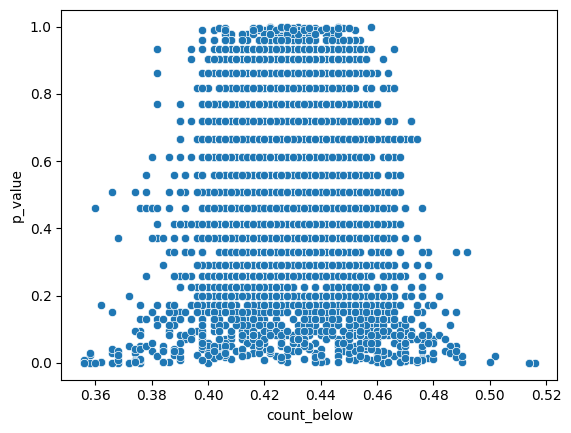

In [278]:
sns.scatterplot(df2[df2.count_below > 0.35].loc[:, ['p_value','count_below']], y = 'p_value', x ='count_below')

In [244]:
df2[df2.count_below > 0.35].shape[0]/df2.shape[0]

0.5058935103644493

In [245]:
df2[df2.count_below > 0.35].Nparameter.unique()

array(['Sigma_individual', 'a', 'z_individual'], dtype=object)

In [246]:
seq = np.arange(0, 1, 0.1)
r = []
i = 0
for a in range(len(seq)):
    if i < len(seq)-1 :
        mask = (df2.count_below >= seq[a]) & (df2.count_below < seq[a+1])
    else:
        mask = (df2.count_below >= seq[a]) 
    r.append([a, a+1, df2[mask].shape[0]/df2.shape[0]])
    i += 1
r


[[0, 1, 0.48828072076954343],
 [1, 2, 0.0005419319875355643],
 [2, 3, 0.0020322449532583662],
 [3, 4, 0.03414171521474055],
 [4, 5, 0.47432597209050265],
 [5, 6, 0.0006774149844194553],
 [6, 7, 0.0],
 [7, 8, 0.0],
 [8, 9, 0.0],
 [9, 10, 0.0]]

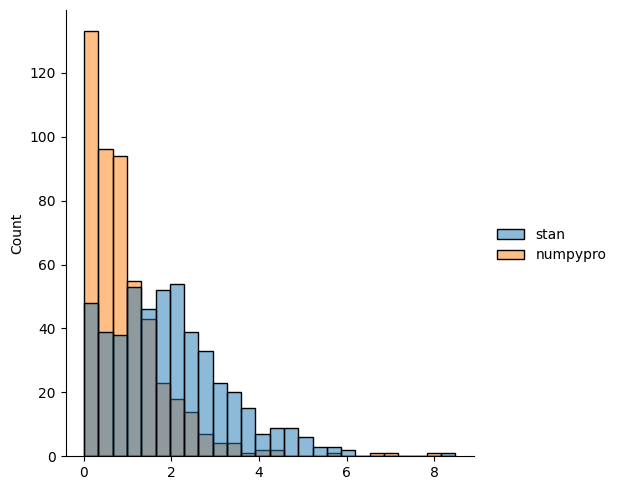

In [247]:
tmp = pd.DataFrame({'stan' : df.loc[:, 'Sigma_individual.4'].values,
                     'numpypro': post['Sigma_individual'][:, 4] # python indexation
                     })
sns.displot(tmp)

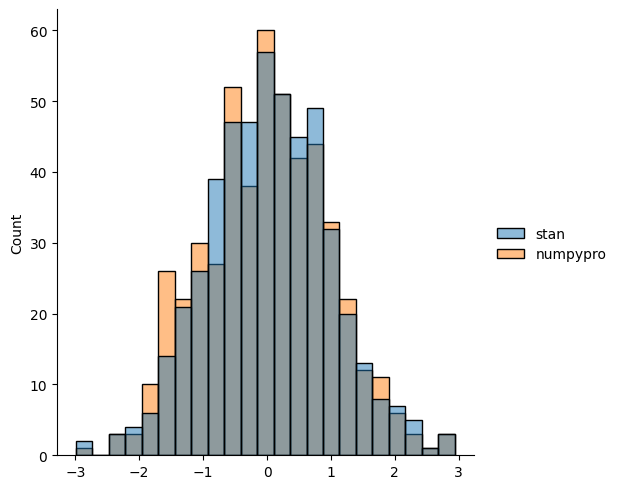

In [248]:
tmp = pd.DataFrame({'stan' : df.loc[:, 'z_individual.56.61'].values,
                     'numpypro': post['z_individual'][:, 55, 60] # python indexation
                     })
sns.displot(tmp)

In [ ]:
tmp['constrast'] = tmp.stan - tmp.numpypro
sns.displot(tmp, x = 'constrast')

# Saving data

In [121]:
import dill    
filename = 'globalsave.pkl'
dill.dump_session(filename)         